In [ ]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, cross_val_predict, cross_val_score
from BorutaShap import BorutaShap
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
development_data = pd.read_csv('../data/raw_data/country_development_data.csv')
development_data.head()

,Country,Obesity,Undernourished,Population,Annual Average Temperature,Max Latitude,Min Latitude,Max Longitude,Min Longitude,HDI Rank,hdi_2016,hdi_2017,hdi_2018,hdi_2019,gdp_2016,gdp_2017,gdp_2018,gdp_2019,code,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature
0,Afghanistan,0.037471,0.478109,0.027721,0.689775,0.602919,0.723203,0.700916,0.694015,0.893617,0.216783,0.211268,0.208850,0.207815,0.596273,0.703846,0.719723,0.876126,0.476531,0.024429,0.476531,0.002857,0.575778,0.710354,0.716581,0.612820
1,Albania,0.454333,0.064799,0.001985,0.671682,0.639673,0.806625,0.547690,0.575061,0.361702,0.716783,0.711268,0.709735,0.712256,0.630435,0.750000,0.820069,0.837838,0.713605,0.001962,0.713605,0.005714,0.598310,0.620379,0.659867,0.644493
2,Algeria,0.555035,0.024518,0.031592,0.888663,0.590785,0.638480,0.521881,0.494401,0.478723,0.638112,0.632042,0.628319,0.628774,0.627329,0.653846,0.726644,0.806306,0.000000,0.028022,0.000000,0.008571,0.757493,0.872619,0.913515,0.816447
3,Angola,0.091335,0.394046,0.023153,0.856803,0.226062,0.337267,0.556283,0.553128,0.781915,0.349650,0.345070,0.338053,0.332149,0.447205,0.596154,0.636678,0.768018,0.002383,0.019921,0.002383,0.017143,0.889659,0.715999,0.634922,0.900425
4,Antigua and Barbuda,0.379391,0.202945,0.000031,0.952521,0.420557,0.622284,0.312344,0.340846,0.409574,0.676573,0.672535,0.674336,0.682060,0.698758,0.723077,0.920415,0.864865,0.238265,0.000030,0.238265,0.020000,0.929101,0.842088,0.799537,0.961075


In [ ]:
country = pd.read_csv('../data/raw_data/regression_targets.csv')
targets = country[['Country', 'Deaths', 'Confirmed', 'Active', 'Recovered']]
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Country      0
Deaths       6
Confirmed    6
Active       8
Recovered    6
dtype: int64


,Country,Deaths,Confirmed,Active,Recovered
0,Afghanistan,0.006186,0.142134,0.012574,0.123374
1,Albania,0.050951,2.967301,1.123714,1.792636
2,Algeria,0.006558,0.244897,0.070767,0.167572
3,Angola,0.001461,0.061687,0.003419,0.056808
4,Antigua and Barbuda,0.007143,0.293878,0.095918,0.190816


In [ ]:
targets.dropna(axis=0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
development_data = development_data.merge(targets, on='Country', how='inner')

In [ ]:
label_values = ['Deaths', 'Active', 'Recovered', 'Confirmed']
features_development = development_data.columns.drop(label_values)
features_development = features_development.drop(['Country', 'WHO code', 'FAO code'])

In [ ]:
X_development = development_data[features_development]
Y_development = development_data[label_values]

In [ ]:
selected_features_development = pd.read_csv('../data/feature_selection/selected_features_rfe_shap_development.csv')
selected_features_development = selected_features_development['selected_features']

In [ ]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=LeaveOneOut())
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [ ]:
def cross_validation_predictions(regressor, data, target, folds=5):
  scores = {}
  n_folds = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=0)
  scores['neg_mean_absolute_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_mean_absolute_error').mean()
  scores['neg_median_absolute_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_median_absolute_error').mean()
  scores['neg_mean_squared_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_mean_squared_error').mean()
  scores['r2'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='r2').mean()
  predictions = cross_val_predict(regressor, data, target, cv=LeaveOneOut())
  return scores, predictions

In [ ]:
PARAMS = {
    'max_depth': [2, 3, 5, 7, 10],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 75, 100, 150, 200, 250, 300, 350]
}

In [ ]:
development_params, development_score = hyper_parameter_search(X_development[selected_features_development], Y_development['Deaths'], PARAMS)

[17:16:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(f'best parameters: {development_params}')
print(f'score: {development_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 200}
score: -0.021720053585850208


In [ ]:
xgb_development = XGBRegressor(gamma = development_params['gamma'],
                               learning_rate = development_params['learning_rate'], 
                               max_depth = development_params['max_depth'],
                               min_child_weight = development_params['min_child_weight'],
                               n_estimators = development_params['n_estimators'])

In [ ]:
scores_development, predictions_development = cross_validation_predictions(xgb_development, X_development[selected_features_development],
                                                             Y_development['Deaths'])

[23:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
scores_development

{'neg_mean_absolute_error': -0.021339454193096637,
 'neg_mean_squared_error': -0.001002824488123525,
 'neg_median_absolute_error': -0.011852972870891177,
 'r2': 0.5552904353199578}

In [ ]:
abs_difs_development = np.abs(predictions_development - Y_development['Deaths'].values)

In [ ]:
ordered_values = []
for i in range(len(abs_difs_development)):
  node = {}
  node['predicted'] = predictions_development[i]
  node['actual'] = Y_development['Deaths'].values[i]
  node['error'] = abs_difs_development[i]
  node['country'] = development_data.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

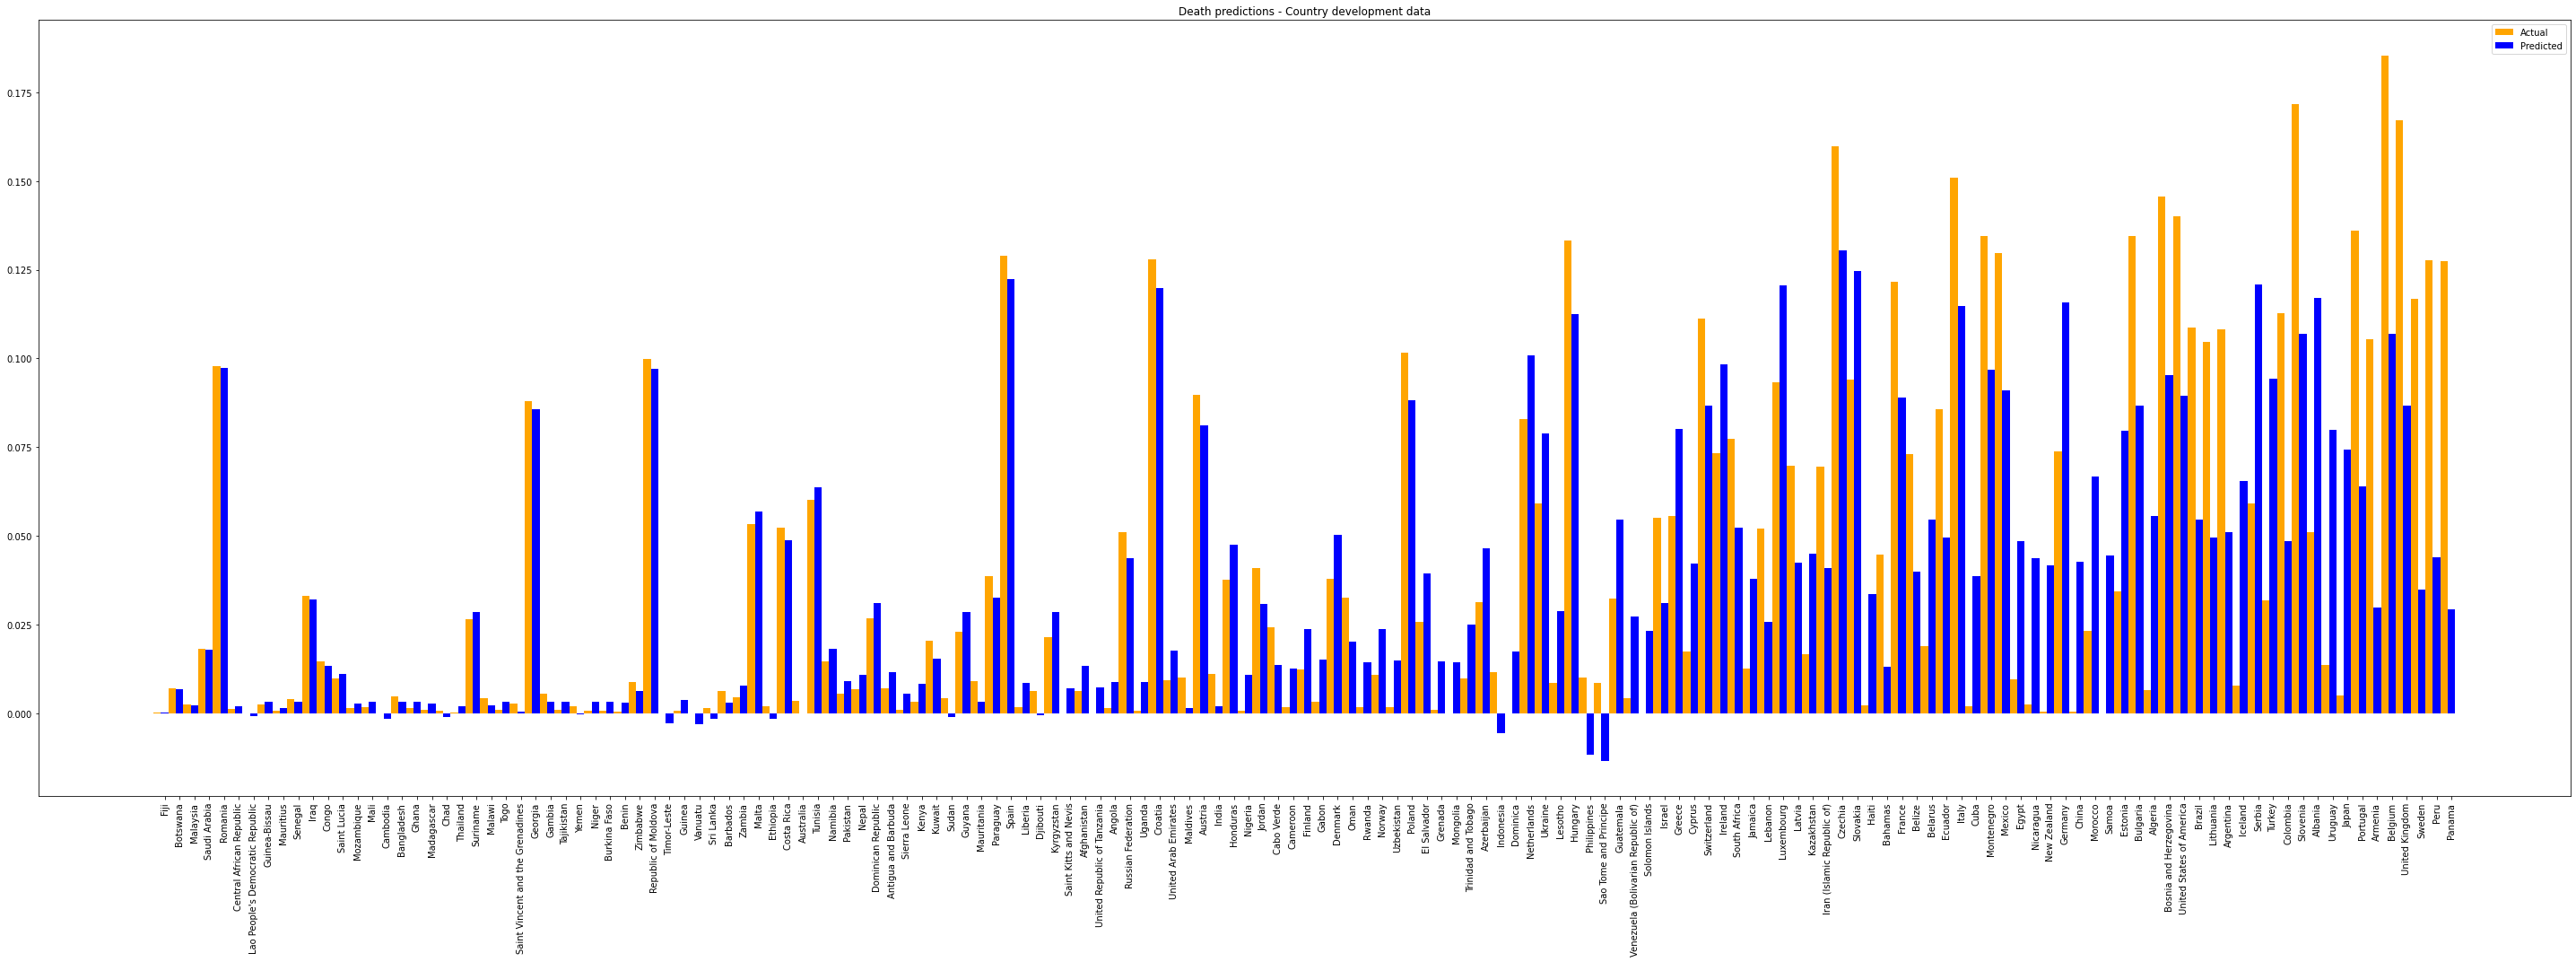

In [ ]:
x = np.arange(1, len(X_development) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
  plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.title('Death predictions - Country development data')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()

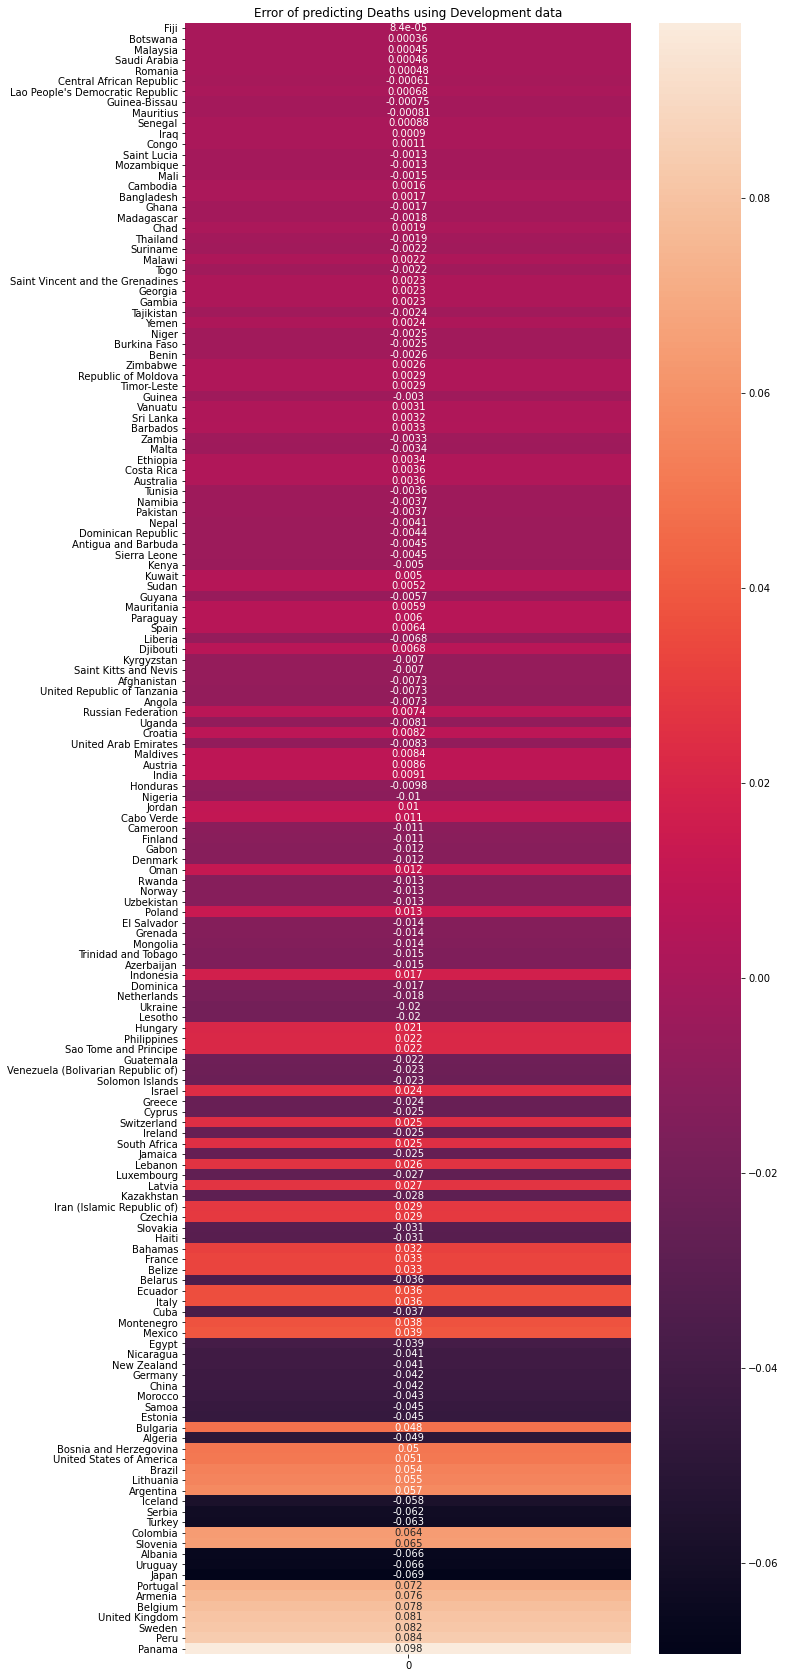

In [ ]:
errors_development = [[val['actual'] - val['predicted']] for val in ordered_values]
countries_development = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_development, annot=True, yticklabels=countries_development)
plt.title("Error of predicting Deaths using Development data")
plt.savefig("Error of predicting Deaths using development data.png")